In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from pathlib import Path
import random
import time

import ssl
import urllib.request

ssl._create_default_https_context = ssl._create_unverified_context

data_path = Path('visual-taxonomy/')
test_image_path = data_path / 'test_images'
train_image_path = data_path / 'train_images'
print(data_path)

device = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_SIZE = 32

visual-taxonomy


In [47]:
df_train = pd.read_csv(data_path / 'train.csv')
df_test = pd.read_csv(data_path / 'test.csv')
print(df_train.describe())
print(df_test.describe())

                 id           len
count  70213.000000  70213.000000
mean   35254.985872      8.850569
std    20295.174166      1.559819
min        0.000000      5.000000
25%    17718.000000      8.000000
50%    35272.000000     10.000000
75%    52825.000000     10.000000
max    70378.000000     10.000000
                 id
count  30205.000000
mean   15298.870386
std     8819.716025
min        0.000000
25%     7623.000000
50%    15371.000000
75%    22937.000000
max    30488.000000


In [48]:
print(df_train.head())
print('---')
print(df_test.head())

   id     Category  len      attr_1 attr_2   attr_3   attr_4         attr_5  \
0   0  Men Tshirts    5     default  round  printed  default  short sleeves   
1   1  Men Tshirts    5  multicolor   polo    solid    solid  short sleeves   
2   2  Men Tshirts    5     default   polo    solid    solid  short sleeves   
3   3  Men Tshirts    5  multicolor   polo    solid    solid  short sleeves   
4   4  Men Tshirts    5  multicolor   polo    solid    solid  short sleeves   

  attr_6 attr_7 attr_8 attr_9 attr_10  
0    NaN    NaN    NaN    NaN     NaN  
1    NaN    NaN    NaN    NaN     NaN  
2    NaN    NaN    NaN    NaN     NaN  
3    NaN    NaN    NaN    NaN     NaN  
4    NaN    NaN    NaN    NaN     NaN  
---
   id     Category
0   0  Men Tshirts
1   1  Men Tshirts
2   2  Men Tshirts
3   3  Men Tshirts
4   4  Men Tshirts


In [49]:
from PIL import Image

In [50]:
'000000.jpg' in os.listdir(train_image_path)

True

In [51]:
train_range = range(len(df_train))
test_range = range(len(df_test))

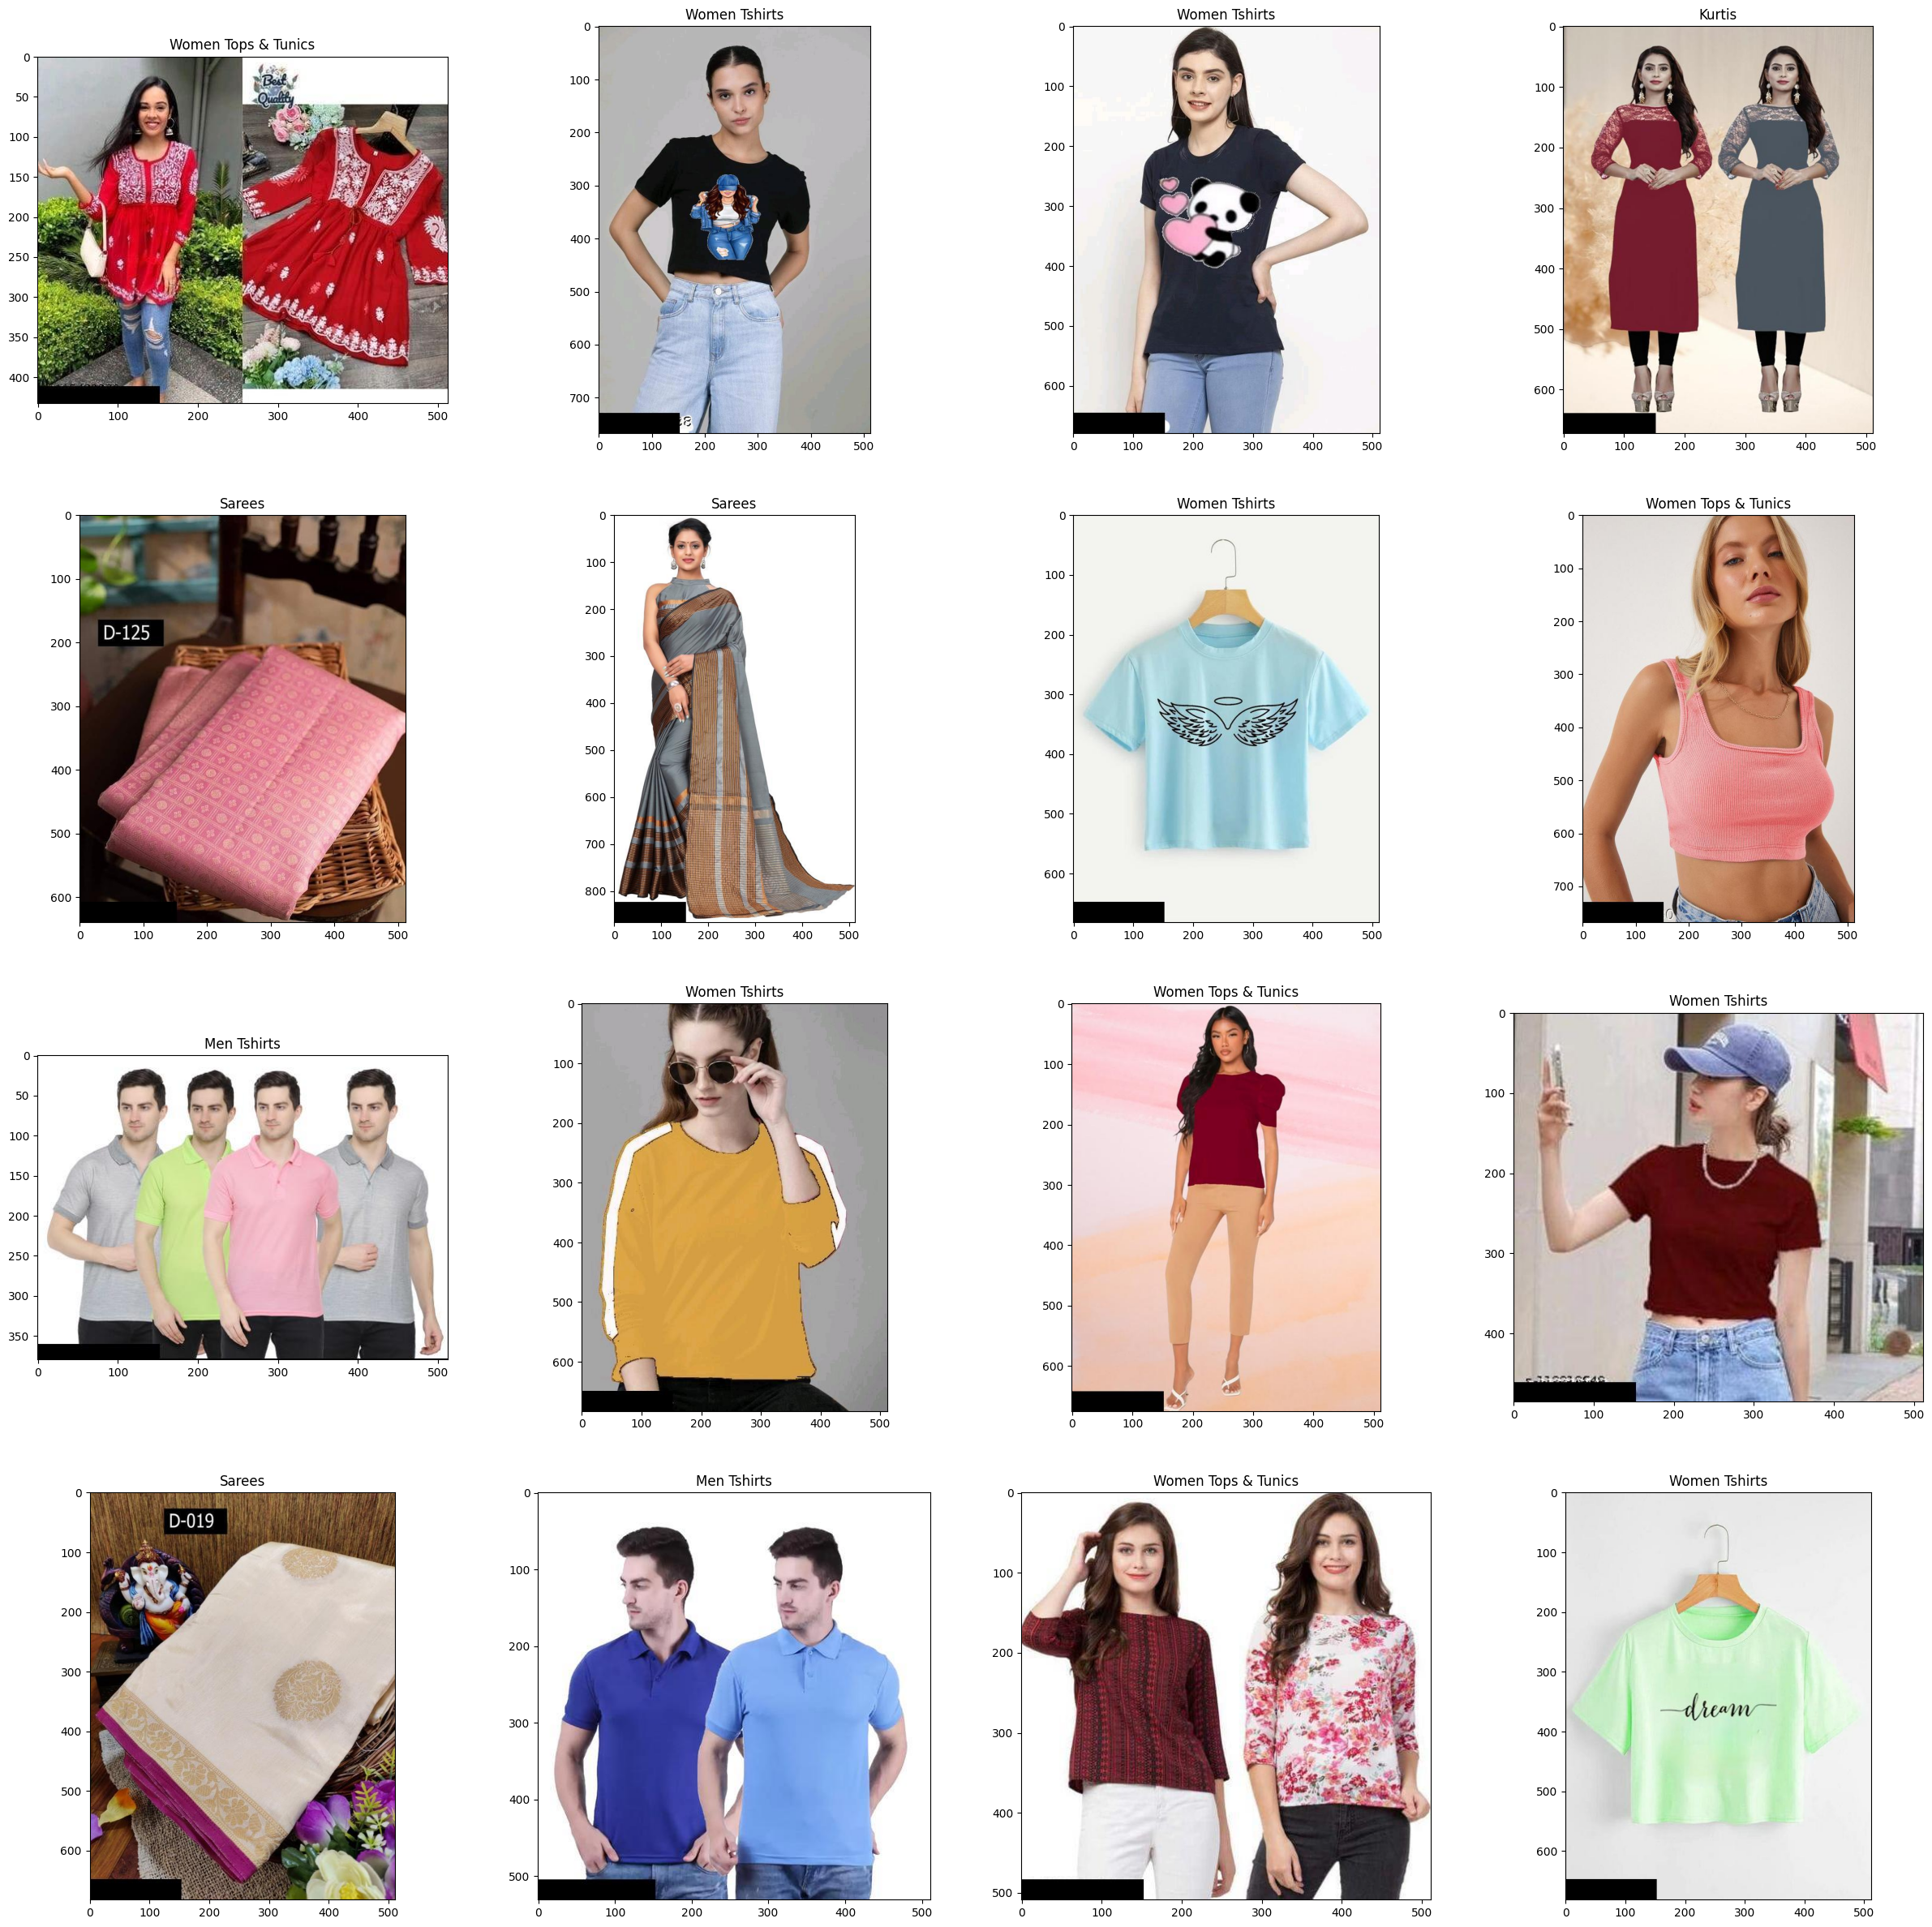

In [52]:
plt.figure(figsize=(30, 30))
for i in range(4):
    for j in range(4):
        idx = random.randint(0, len(df_train))
        img = Image.open(train_image_path / f'{idx:06d}.jpg')
        plt.subplot(4, 4, 4 * i + j + 1)

        plt.imshow(img)
        plt.title(df_train.loc[idx, 'Category'])
    
plt.show()



In [53]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch import optim


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

In [54]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


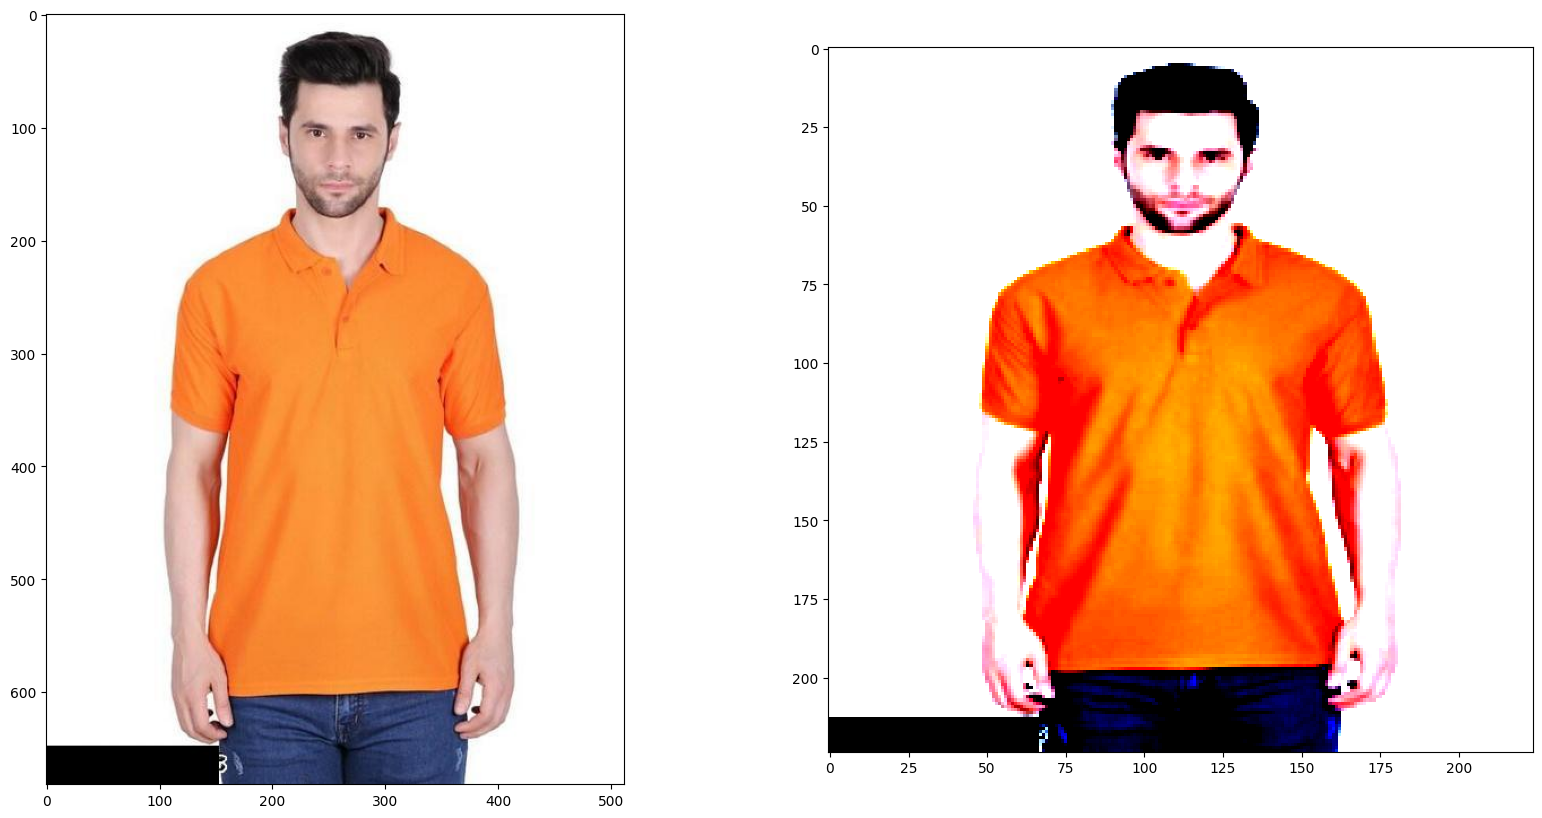

Men Tshirts


In [55]:
num = 560
img = Image.open(train_image_path / f'{num:06d}.jpg')
img_1 = data_transform(img)
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img_1.permute(1, 2, 0))
plt.show()
print(df_train.loc[num, 'Category'])

In [56]:
df_train['Category'].value_counts()

Category
Women Tops & Tunics    19004
Women Tshirts          18774
Sarees                 18346
Men Tshirts             7267
Kurtis                  6822
Name: count, dtype: int64

In [57]:
values = [df_train[col].unique() for col in df_train.columns]
print(values)

[array([    0,     1,     2, ..., 70376, 70377, 70378]), array(['Men Tshirts', 'Sarees', 'Kurtis', 'Women Tshirts',
       'Women Tops & Tunics'], dtype=object), array([ 5, 10,  9,  8]), array(['default', 'multicolor', 'black', 'white', nan, 'same as saree',
       'solid', 'same as border', 'red', 'navy blue', 'maroon', 'green',
       'pink', 'blue', 'purple', 'grey', 'yellow', 'orange', 'peach'],
      dtype=object), array(['round', 'polo', nan, 'woven design', 'zari', 'no border', 'solid',
       'default', 'temple border', 'straight', 'a-line', 'loose', 'boxy',
       'regular', 'fitted'], dtype=object), array(['printed', 'solid', nan, 'small border', 'big border', 'no border',
       'knee length', 'calf length', 'long', 'crop', 'regular'],
      dtype=object), array(['default', 'solid', nan, 'typography', 'multicolor', 'cream',
       'white', 'navy blue', 'yellow', 'green', 'pink', 'daily', 'party',
       'printed', 'high', 'round neck', 'stylised', 'sweetheart neck',
       '

In [58]:
list(values[1]).index('Men Tshirts')

0

In [59]:
def convert_attributes_to_tensor(df):
    attr_list = [list(values[i]).index(df.iloc[i]) for i in range(1, len(df))]
    return torch.tensor(attr_list)

In [60]:
convert_attributes_to_tensor(df_train.loc[10000])

tensor([1, 1, 4, 3, 2, 4, 6, 0, 0, 0, 0, 1])

In [61]:
class CustomDataset(Dataset):

    def __init__(self, 
                root_dir: str,
                root_csv: str,
                transform=None):

        self.root_dir = root_dir
        self.root_csv = root_csv
        self.transform = transform

    def __len__(self):
        return len(self.root_csv)

    def __getitem__(self, idx):

        img = Image.open(self.root_dir / f'{idx:06d}.jpg')
        transformed_img = self.transform(img)

        attributes = convert_attributes_to_tensor(self.root_csv.loc[idx])

        return transformed_img, attributes


In [62]:
train_dataset = CustomDataset(train_image_path, df_train, data_transform)
test_dataset = CustomDataset(test_image_path, df_test, data_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 3,  3,  1, 13,  9, 13,  9,  6,  6,  0,  0,  0])
Women Tshirts


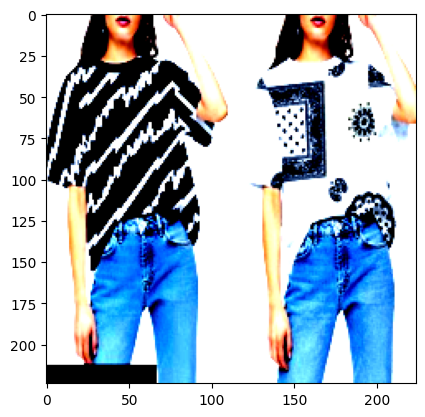

In [63]:
image, label = train_dataset[40000]
plt.imshow(image.permute(1, 2, 0))
print(label)
print(values[1][label[0]])

In [64]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [65]:
next(iter(train_loader))

[tensor([[[[ 0.1254,  0.1426,  0.1426,  ..., -0.1143, -0.1828,  0.1254],
           [-0.0116,  0.1083,  0.0741,  ..., -0.0287, -0.0287, -0.0801],
           [-0.2856, -0.0629, -0.0458,  ..., -0.0458, -0.1828, -0.1486],
           ...,
           [-2.1179, -2.1179, -2.1179,  ...,  0.1768,  0.7591,  0.6392],
           [-2.1179, -2.1179, -2.1179,  ...,  0.4508,  0.2111,  0.3138],
           [-2.1179, -2.1179, -2.1179,  ...,  0.3309, -0.0458, -0.1657]],
 
          [[-0.4951, -0.4776, -0.4776,  ..., -0.6001, -0.7227, -0.4426],
           [-0.6352, -0.5126, -0.5476,  ..., -0.5476, -0.5826, -0.7052],
           [-0.8803, -0.6527, -0.6352,  ..., -0.5826, -0.8102, -0.8452],
           ...,
           [-2.0357, -2.0357, -2.0357,  ...,  0.2577,  0.8354,  0.6954],
           [-2.0357, -2.0357, -2.0357,  ...,  0.5378,  0.2752,  0.3627],
           [-2.0357, -2.0357, -2.0357,  ...,  0.4328,  0.0301, -0.1275]],
 
          [[-1.0550, -1.0376, -1.0376,  ..., -1.0201, -1.1770, -0.8807],
           [-

In [66]:
dataloaders = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset)}

In [67]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [68]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {values[0][preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [69]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [70]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


RuntimeError: 0D or 1D target tensor expected, multi-target not supported